Model

A pre-trained BERT model was used from Hugging Face (bert-base-uncased). The code used is similar to the notebook used in the final assignment. The model was trained both on data that was and was not preprocessed.

Results

The highest accuracy acheived was approximately 78%. The model had an almost 10% increase in accuracy when it was trained on data that was not preprocessed (stop words not removed, text not lemmatized, etc) compared to preprocessed text.

Resources Used:

*   Final Assignment notebook (P2)
*   [Tokenizer](https://huggingface.co/docs/transformers/main_classes/tokenizer?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus)
*   [BERT](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html)





## Imports

In [ ]:
# !pip install transformers
# !pip install wget
# !pip install sentencepiece

In [ ]:
import tensorflow as tf
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig

import wget
import os
import pandas as pd
import numpy as np
import time
import datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Definitions

In [ ]:
PATH = "path"
train_path = os.path.join(PATH,"train-unprocessed.csv")
val_path = os.path.join(PATH,"val-unprocessed.csv")
test_path = os.path.join(PATH,"test-unprocessed.csv")
merged_path = os.path.join(PATH,"merged.csv")

## Load Data

In [ ]:
train = pd.read_csv(train_path)
val = pd.read_csv(val_path)
test = pd.read_csv(test_path)
all = pd.read_csv(merged_path)

In [ ]:
train_sentences = train["sentence"].tolist()
train_labels = train["label"].tolist()

val_sentences = val["sentence"].tolist()
val_labels = val["label"].tolist()

test_sentences = test["sentence"].tolist()
test_labels = test["label"].tolist()

all_sentences = all["sentence"].tolist()

## Data Loaders

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
max_len = 0
for sent in all_sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print(f'Longest sentence in the dataset is: {max_len}')

Longest sentence in the dataset is: 139


In [ ]:
def getDataloader(sentences,labels, max_len):
  batch_size = 16
  input_ids = []
  attention_masks = []
  for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  dataset = TensorDataset(input_ids, attention_masks, labels)
  dataloader = DataLoader(
            dataset,
            sampler = RandomSampler(dataset),
            batch_size = batch_size
        )
  return dataloader

In [ ]:
train_dataloader = getDataloader(train_sentences,train_labels, max_len)
validation_dataloader = getDataloader(val_sentences,val_labels, max_len)
test_dataloader = getDataloader(test_sentences,test_labels, max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Define Model

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters in the pre-trained BERT model: {params}")

Number of parameters in the pre-trained BERT model: 109483778


## Helper Methods

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


## Training

In [ ]:
epochs = 4
earlyStop = 1
WEIGHTS_PATH = "/bert.pt"

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
seed_val = 10

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
# best_val_loss = float("inf")
# count_no_improvements = 0
# flag = 0

total_t0 = time.time()

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()

        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # if total_eval_loss<best_val_loss:
    #       best_val_loss = total_eval_loss
    #       torch.save(model.state_dict(), WEIGHTS_PATH)
    #       count_no_improvements = 0
    # else:
    #   count_no_improvements+=1
    #   if count_no_improvements>earlyStop:
    #     flag = 1
    #     break

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     47.    Elapsed: 0:00:15.

  Average training loss: 0.62
  Training epcoh took: 0:00:17
  Accuracy: 0.77
  Validation Loss: 0.50
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     47.    Elapsed: 0:00:14.

  Average training loss: 0.47
  Training epcoh took: 0:00:16
  Accuracy: 0.78
  Validation Loss: 0.45
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     47.    Elapsed: 0:00:14.

  Average training loss: 0.32
  Training epcoh took: 0:00:16
  Accuracy: 0.79
  Validation Loss: 0.47
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     47.    Elapsed: 0:00:14.

  Average training loss: 0.24
  Training epcoh took: 0:00:16
  Accuracy: 0.80
  Validation Loss: 0.48
  Validation took: 0:00:01

Training complete!


## Testing

In [ ]:
pd.set_option('display.precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

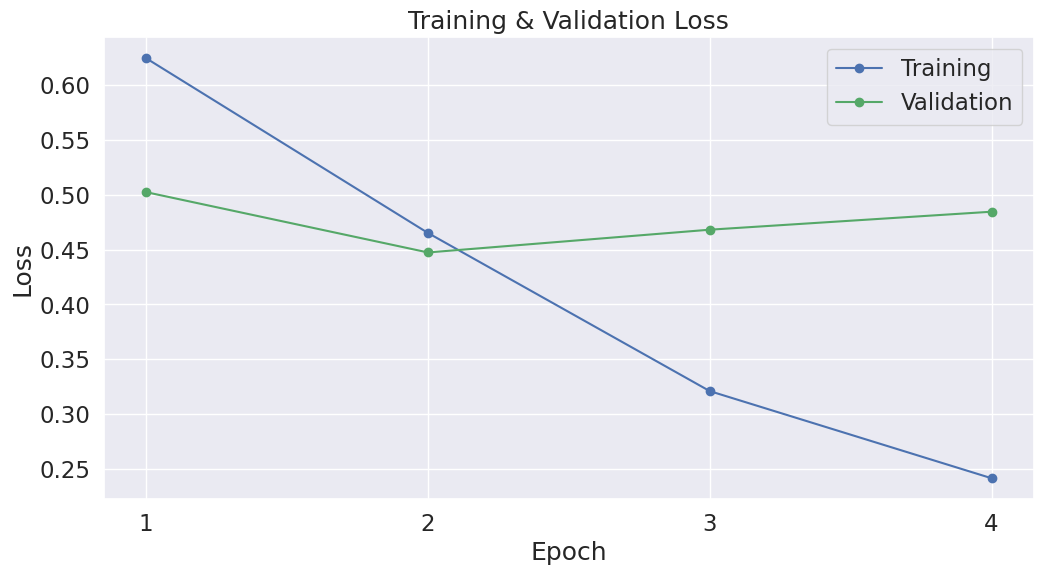

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
model.eval()

predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

predictions = np.concatenate([np.argmax(logits, axis=1) for logits in predictions])
true_labels = np.concatenate(true_labels)

accuracy = np.mean(predictions == true_labels)
print(f"Accuracy on the test set: {accuracy}")

Accuracy on the test set: 0.6979166666666666
